# Q-learning implementation

$$
    Q^{\text{new}}(s_t, a_t) = Q(s_t, a_t) + \alpha \left(r_t + \gamma \max_\alpha Q(S_{t+1}, a) - Q(s_t, a_t)\right)
$$

Example implementation with $\alpha=1$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from numpy.random import seed, choice, randint

In [2]:
%precision 2
%config InlineBackend.figure_format = "retina"

## The setting

In [3]:
list_links = [(0,6), (1,5), (5,6), (5,4), (1,2), (2,3), (2,7)]
links = np.array(list_links)

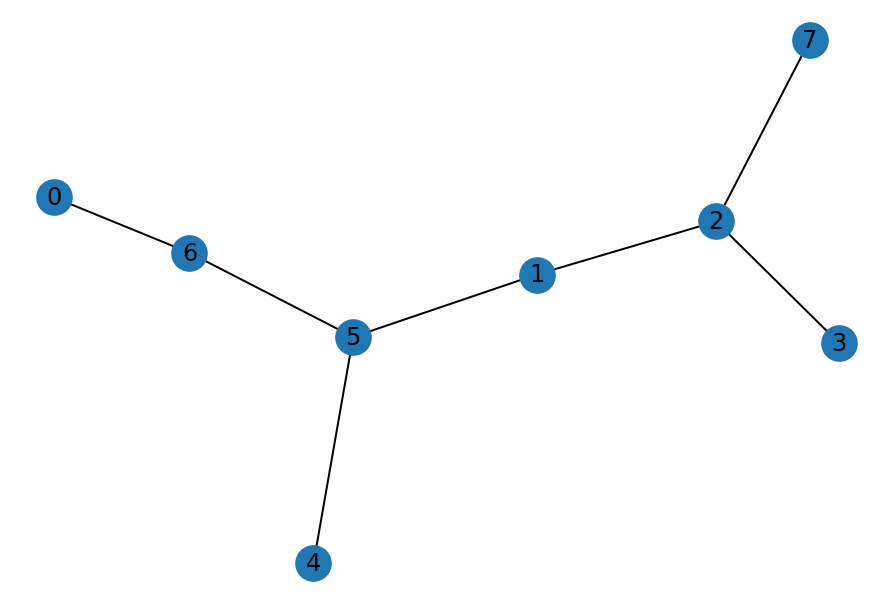

In [4]:
target = 7

G = nx.Graph()
G.add_edges_from(links)
pos = nx.spring_layout(G, seed=27182)
nx.draw(G, pos, with_labels=True)

In [5]:
n_nodes = len(links) + 1
# R is the reward matrix
R = -np.ones((n_nodes, n_nodes))

In [6]:
# There is no cost to traverse the tree forwards
R[links[:, 0], links[:, 1]] = 0
# There is no cost to traverse the tree backwards
R[links[:, 1], links[:, 0]] = 0

In [7]:
# Value points for reaching the target
from_links, target_links = links[links[:, 1] == target].T
R[from_links, target] = 100
# target point for making it
R[target, target] = 100 

In [8]:
def create_reward_matrix(links, target_node):
    n_nodes = len(links) + 1
    R = -np.ones((n_nodes, n_nodes))
    # There is no cost to traverse the tree forwards
    R[links[:, 0], links[:, 1]] = 0
    # There is no cost to traverse the tree backwards
    R[links[:, 1], links[:, 0]] = 0
    # Value points for reaching the target_node
    from_links, target_links = links[links[:, 1] == target_node].T
    R[from_links, target_node] = 100
    # target_node point for making it
    R[target_node, target_node] = 100
    
    return R

In [9]:
# (from, to)
pd.DataFrame(R, index=np.arange(n_nodes), columns=np.arange(n_nodes))

,0,1,2,3,4,5,6,7
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
1,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0
2,-1.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,100.0
3,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0
5,-1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0
6,0.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0
7,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,100.0


## The learning algorithm: Learn the best policy $Q$

```
1. Set the gamma parameter, and environment rewards in matrix R.

2. Initialize matrix Q to zero.

3. For each episode:
    Select a random initial state.
    Do While the goal state hasn't been reached.
        A. Select one among all possible actions for the current state.
        B. Using this possible action, consider going to the next state.
        C. Get maximum Q value for this next state based on all possible actions.
        D. Compute: Q(state, action) = R(state, action) + Gamma * Max[Q(next state, all actions)]
        E. Set the next state as the current state.
    End Do
End For
```

* The rows of matrix Q represent the current state of the agent, and the columns represent the possible actions leading to the next state (the links between the nodes)


In [10]:
Q = np.zeros_like(R)
gamma = 0.8

In [11]:
state = 5

In [12]:
def get_actions(state, R):
    actions = R[state, :]
    possible_actions, *_ = np.where(actions >= 0)
    return possible_actions

get_actions(state, R)

array([1, 4, 6])

In [13]:
def take_random_action(state, R):
    actions = get_actions(state, R)
    next_action = choice(actions)
    
    return next_action

# sample action => a new state
take_random_action(state, R)

6

In [14]:
seed(314) 
action = take_random_action(state, R)

def get_state(action):
    """
    This function can be more complicated
    A given action takes you to a state. The
    transition matrix need not be symmetric
    """
    return action

new_state = get_state(action)
new_state

1

In [15]:
state, new_state

(5, 1)

In [16]:
# How much did it help you take the current step
# Q[state, a] = Q[state, a] + (R[state, action] + gamma * Q[new_state, :].max())
Q[state, action] = (R[state, action] + gamma * Q[new_state, :].max())
Q[state, action]

0.0

In [17]:
# ... iterate

In [18]:
def q_step(Q, R, state, gamma):
    action = take_random_action(state, R)
    new_state = get_state(action)
    Q_val = R[state, action] + gamma * Q[new_state, :].max()
    
    return Q_val, (action, new_state)

seed(314)
q_new, (action, new_state) = q_step(Q, R, state, gamma)
Q[state, action] = q_new
state = new_state

In [19]:
def run_episode(Q, R, gamma, state_init, target):
    Q = Q.copy()
    state = state_init
    while state != target:
        q_new, (action, new_state) = q_step(Q, R, state, gamma)
        Q[state, action] = q_new
        state = new_state
        
    q_new, (action, new_state) = q_step(Q, R, state, gamma)
    Q[state, action] = q_new
    return Q

In [20]:
run_episode(Q, R, gamma, state_init=5, target=target)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  80.,   0.,   0.,   0.,   0.,   0.]])

In [21]:
def q_learn(R, gamma, target, n_its=10):
    Q = np.zeros_like(R)
    for _ in range(n_its):
        state_init = randint(len(R))
        Q = run_episode(Q, R, gamma, state_init, target)
    return Q / Q.max()

In [22]:
seed(314)
target = 7
Q_learned = q_learn(R, gamma, target=target, n_its=200)
Q_learned

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.41, 0.  ],
       [0.  , 0.  , 0.8 , 0.  , 0.  , 0.51, 0.  , 0.  ],
       [0.  , 0.64, 0.  , 0.64, 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.51, 0.  , 0.  ],
       [0.  , 0.64, 0.  , 0.  , 0.41, 0.  , 0.41, 0.  ],
       [0.33, 0.  , 0.  , 0.  , 0.  , 0.51, 0.  , 0.  ],
       [0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [23]:
def find_answer(Q, s_init, target):
    steps = [s_init]
    step = s_init
    while step != target:
        step = Q[step].argmax()
        steps.append(step)
    return steps

In [24]:
s_init = 0
optimal_path = find_answer(Q_learned, s_init, 7)
optimal_path

[0, 6, 5, 1, 2, 7]

In [25]:
nodes_path = [(init, end) for init, end in
              zip(optimal_path[:-1], optimal_path[1:])]

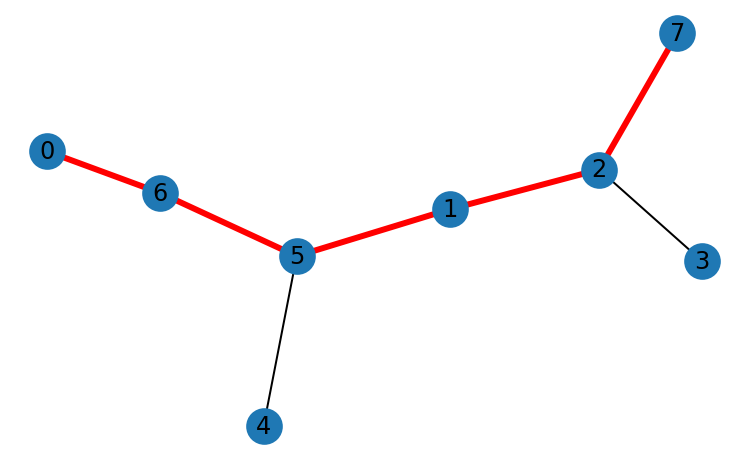

In [26]:
plt.figure(figsize=(5, 3))
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, edgelist=nodes_path,
                       edge_color="r",width=3);

## All together

In [27]:
def create_reward_matrix(links, target_node):
    n_nodes = len(links) + 1
    R = -np.ones((n_nodes, n_nodes))
    # There is no cost to traverse the tree forwards
    R[links[:, 0], links[:, 1]] = 0
    # There is no cost to traverse the tree backwards
    R[links[:, 1], links[:, 0]] = 0
    # Value points for reaching the target_node
    from_links, target_links = links[links[:, 1] == target_node].T
    R[from_links, target_node] = 100
    # target_node point for making it
    R[target_node, target_node] = 100
    
    return R

def get_actions(state, R):
    actions = R[state, :]
    possible_actions, *_ = np.where(actions >= 0)
    return possible_actions


def take_random_action(state, R):
    actions = get_actions(state, R)
    next_action = choice(actions)
    
    return next_action


def get_state(action):
    """
    This function can be more complicated
    A given action takes you to a state. The
    transition matrix need not be symmetric
    """
    return action


def q_step(Q, R, state, gamma):
    action = take_random_action(state, R)
    new_state = get_state(action)
    Q_val = R[state, action] + gamma * Q[new_state, :].max()
    
    return Q_val, (action, new_state)


def run_episode(Q, R, gamma, state_init, target):
    Q = Q.copy()
    state = state_init
    while state != target:
        q_new, (action, new_state) = q_step(Q, R, state, gamma)
        Q[state, action] = q_new
        state = new_state
        
    q_new, (action, new_state) = q_step(Q, R, state, gamma)
    Q[state, action] = q_new
    return Q


def q_learn(R, gamma, target, n_its=10):
    Q = np.zeros_like(R)
    for _ in range(n_its):
        state_init = randint(len(R))
        Q = run_episode(Q, R, gamma, state_init, target)
    return Q / Q.max()

In [28]:
seed(314)
links = np.array([(0,6), (1,5), (5,6), (5,4), (1,2), (2,3), (2,7)])
target = 1

R = create_reward_matrix(links, target)

Q_learned = q_learn(R, gamma, target=target, n_its=200)
Q_learned


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.51, 0.  ],
       [0.  , 1.  , 0.64, 0.  , 0.  , 0.64, 0.  , 0.  ],
       [0.  , 0.8 , 0.  , 0.51, 0.  , 0.  , 0.  , 0.51],
       [0.  , 0.  , 0.64, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.64, 0.  , 0.  ],
       [0.  , 0.8 , 0.  , 0.  , 0.51, 0.  , 0.51, 0.  ],
       [0.41, 0.  , 0.  , 0.  , 0.  , 0.64, 0.  , 0.  ],
       [0.  , 0.  , 0.64, 0.  , 0.  , 0.  , 0.  , 0.  ]])

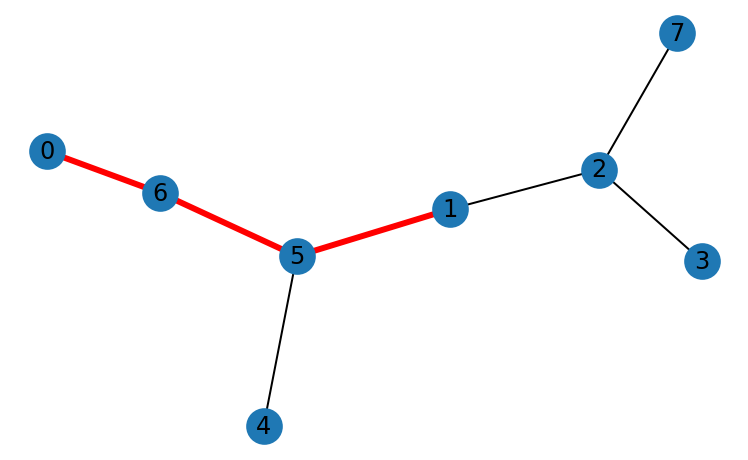

In [29]:
s_init = 0
optimal_path = find_answer(Q_learned, s_init, target)
optimal_path

nodes_path = [(init, end) for init, end in
              zip(optimal_path[:-1], optimal_path[1:])]

plt.figure(figsize=(5, 3))
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, edgelist=nodes_path,
                       edge_color="r",width=3);

### References
* http://mnemstudio.org/path-finding-q-learning-tutorial.htm